## How good is the strategy?

#### Import packages

In [1]:
# import data packages
import pandas as pd
import numpy as np
from scipy.stats import t as t_test
import datetime
import matplotlib.pyplot as plt



In [3]:
#import all bets:
all_bets = pd.read_csv('analysis/results/all_bets2.csv', index_col=0)

,Datetime,Horse,Type,Location,Price,Midpoint Price,Amount,6.5,3.2,Venue,Midpoint Percentage,WIN_LOSE,BSP,Turnover,Expected Value
0,2023-01-04,Abreed,RaceType.HORSE_RACE,AUS,8.50,8.341066,1.0,1.0,1.0,Geelong,0.981302,0,9.554885,88.959729,-0.110403
1,2023-01-04,Angry Ann,RaceType.GREYHOUND_RACE,AUS,6.50,6.182857,1.0,1.0,1.0,Richmond,0.951209,1,4.961008,131.021753,0.310218
2,2023-01-04,Another Cognac,RaceType.HORSE_RACE,AUS,6.50,6.382609,1.0,1.0,1.0,Warwick Farm,0.981940,1,4.471198,145.374904,0.453749
3,2023-01-04,Big Time Brynley,RaceType.GREYHOUND_RACE,AUS,1.80,1.734172,1.0,1.0,1.0,Manawatu,0.963429,0,1.847211,97.444200,-0.025558
4,2023-01-04,Candy Kaos,RaceType.GREYHOUND_RACE,AUS,5.00,4.750000,1.0,1.0,1.0,Taree,0.950000,0,5.583165,89.554936,-0.104451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,2022-12-16,Sweet Dynasty,RaceType.HORSE_RACE,USA,4.20,3.928571,1.0,1.0,1.0,Remington Park,0.935374,0,4.128402,101.734281,0.017343
600,2022-12-16,Tashkent,RaceType.HORSE_RACE,USA,3.00,99995.000000,1.0,1.0,1.0,Remington Park,33331.666667,1,1.730920,173.318279,0.733183
601,2022-12-16,Whiskey Reef,RaceType.GREYHOUND_RACE,AUS,3.00,2.975385,1.0,1.0,1.0,Ballarat,0.991795,0,2.814156,106.603892,0.066039
602,2022-12-16,Whisky Nip,RaceType.GREYHOUND_RACE,AUS,4.20,4.233333,1.0,1.0,1.0,Ballarat,1.007937,1,3.600000,116.666667,0.166667


#### Manipualte base data

In [12]:
all_bets['midpoint turnover'] = (all_bets['Midpoint Price'] / all_bets['BSP'])
all_bets['midpoint turnover'] = (all_bets['Midpoint Price'] / all_bets['BSP'])
all_bets['profit/loss'] = np.where(all_bets['WIN_LOSE'] == 1, (all_bets['Price'] * 1) - 1, -1)
all_bets['winnings'] = np.where(all_bets['WIN_LOSE'] == 1, (all_bets['Price'] * 1), 0)
all_bets['kelly'] = np.where(all_bets['WIN_LOSE'] == 1, (all_bets['Price'] * 1), 0)
all_bets['implied_probability'] = 1 / all_bets['Price']
#let's filter the data to only observations where the price > midpoint price:
midpoint_strat_profit = all_bets[all_bets['Price'] > all_bets['Midpoint Price']]
profit = sum(all_bets['profit/loss'])
winnings = sum(all_bets['winnings'])
returns = profit / len(all_bets) * 100

# let's group the data by characteristics and see if there is a difference in key metrics:
location_returns = all_bets.groupby('Location')['profit/loss'].sum()
location_returns_n = all_bets.groupby('Location')['Horse'].count()
location_returns_t = all_bets.groupby('Location')['Turnover'].mean()
location_returns = pd.DataFrame(location_returns.sort_values(ascending=False)).merge(location_returns_n, left_index=True, right_index=True)
location_returns = location_returns.merge(location_returns_t, left_index=True, right_index=True)

venue_returns = all_bets.groupby('Venue')['profit/loss'].sum()
venue_returns_n = all_bets.groupby('Venue')['Horse'].count()
venure_returns_t = all_bets.groupby('Venue')['Turnover'].mean()
venue_returns = pd.DataFrame(venue_returns.sort_values(ascending=False)).merge(venue_returns_n, left_index=True, right_index=True)
venue_returns = venue_returns.merge(venure_returns_t, left_index=True, right_index=True)

race_type_returns = all_bets.groupby('Type')['profit/loss'].sum()
race_type_returns_n = all_bets.groupby('Type')['Horse'].count()
race_type_returns_t = all_bets.groupby('Type')['Turnover'].mean()
race_type_returns = pd.DataFrame(race_type_returns.sort_values(ascending=False)).merge(race_type_returns_n, left_index=True, right_index=True)
race_type_returns = race_type_returns.merge(race_type_returns_t, left_index=True, right_index=True)

In [5]:
# let's group the data by price and see if there is a difference in profit/loss and turnover by price:
conditions = [(all_bets['Price'] >= 1) & (all_bets['Price'] < 2),
                (all_bets['Price'] >= 2) & (all_bets['Price'] < 4),
                (all_bets['Price'] >= 4) & (all_bets['Price'] < 6),
                (all_bets['Price'] >= 6) & (all_bets['Price'] < 8),
                (all_bets['Price'] >= 8) & (all_bets['Price'] < 10),
                (all_bets['Price'] >= 10) & (all_bets['Price'] < 12),
                (all_bets['Price'] >= 12) & (all_bets['Price'] < 14),
                (all_bets['Price'] >= 14) & (all_bets['Price'] < 16),
                (all_bets['Price'] >= 16) & (all_bets['Price'] < 18),
                (all_bets['Price'] >= 18) & (all_bets['Price'] < 20),
                (all_bets['Price'] >= 20)]

price_group = ["1-2", "2-4", "4-6", "6-8", "8-10", "10-12", "12-14", "14-16", "16-18", "18-20", "20+"]

all_bets['price_group'] = np.select(conditions, price_group)

price_type_returns = all_bets.groupby('price_group')['profit/loss'].sum()
price_type_returns_n = all_bets.groupby('price_group')['Horse'].count()
price_type_returns_t = all_bets.groupby('price_group')['Turnover'].mean()
price_type_returns = pd.DataFrame(price_type_returns).merge(price_type_returns_n, left_index=True, right_index=True)
price_type_returns = price_type_returns.merge(price_type_returns_t, left_index=True, right_index=True)

#### How good are our bets thus far?

In [6]:
print(f'From a total of {len(all_bets)} bets, betting $1 on every horse yielded a total profit of: ${profit}')
print(f'This equates to a return on investment (${len(all_bets)} base investment) of: {round(returns, 3)} percent.')

display(location_returns)
display(price_type_returns)
display(race_type_returns)
display(venue_returns)

From a total of 604 bets, betting $1 on every horse yielded a total profit of: $-10.549999999999997
This equates to a return on investment ($604 base investment) of: -1.747 percent.


,profit/loss,Horse,Turnover
Location,,,
AUS,36.10,513,105.438481
USA,-46.65,91,106.965810


,profit/loss,Horse,Turnover
price_group,,,
1-2,2.90,28,101.258010
10-12,-17.00,87,109.554595
2-4,-34.95,129,102.615151
4-6,-21.00,154,105.298893
6-8,0.00,124,111.257619
8-10,59.50,82,100.097885


,profit/loss,Horse,Turnover
Type,,,
RaceType.GREYHOUND_RACE,43.00,219,104.104008
RaceType.TROT_RACE,5.70,132,106.010643
RaceType.HORSE_RACE,-59.25,253,106.844454


,profit/loss,Horse,Turnover
Venue,,,
Shepparton,17.55,12,102.400859
Ballarat,14.50,20,106.154679
Menangle,14.50,7,100.865919
Horsham,12.00,3,134.727316
Tamworth,12.00,17,122.606692
...,...,...,...
Traralgon,-7.50,10,100.062121
Taree,-9.45,11,115.548936
Geelong,-13.40,18,106.123984


In [23]:
all_bets['aus_horse_race'] = np.where((all_bets['Location'] == 'AUS') & (all_bets['Type'] == 'RaceType.HORSE_RACE'), 1, 0)
aus_horse_returns_p = all_bets.groupby('aus_horse_race')['profit/loss'].sum()
aus_horse_returns_t = all_bets.groupby('aus_horse_race')['Turnover'].mean()
aus_horse_n = all_bets.groupby('aus_horse_race')['Horse'].count()
aus_horse_returns = pd.DataFrame(aus_horse_returns_p).merge(aus_horse_n, left_index=True, right_index=True)
aus_horse_returns = aus_horse_returns.merge(aus_horse_returns_t, left_index=True, right_index=True)
aus_horse_returns

C:\Users\bened\AppData\Local\Temp\ipykernel_18488\3177747289.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Horse_x'} in the result is deprecated and will raise a MergeError in a future version.
  price_type_returns = pd.DataFrame(price_type_returns).merge(price_type_returns_n, left_index=True, right_index=True)
C:\Users\bened\AppData\Local\Temp\ipykernel_18488\3177747289.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Turnover_x'} in the result is deprecated and will raise a MergeError in a future version.
  price_type_returns = price_type_returns.merge(price_type_returns_t, left_index=True, right_index=True)


,profit/loss,Horse,Turnover
aus_horse_race,,,
0,2.05,442,105.262605
1,-12.60,162,106.776284


Unlucky, or BSP not all its cracked up to be?

In [7]:
mean = all_bets['profit/loss'].mean()
signma = all_bets['profit/loss'].std()
n = len(all_bets)
dof = n -1
mu = (all_bets['Turnover'].mean() / 100) - 1
#t test:
t = (mean - mu) / (signma / np.sqrt(n))
t_test.cdf(t, dof)
p_value = 2*(1 - t_test.cdf(abs(t), dof))
p_value

0.4192408363974547

#### How indicative of the BSP is the midpoint price?

On average the midpoint price is $-827.357 off from the BSP


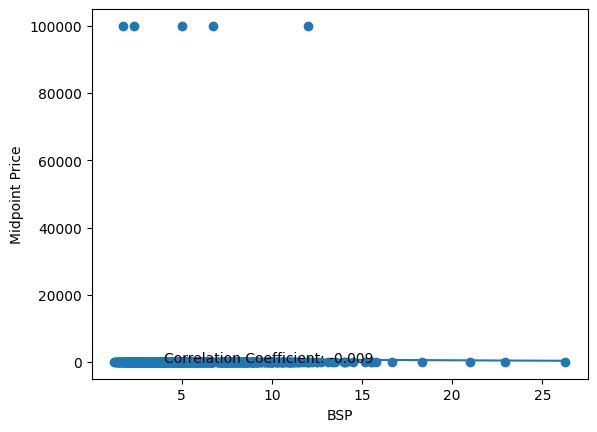

In [8]:
# Let's calculate how far off the midpoint price is from BSP
all_bets['midpoint difference'] = all_bets['BSP'] - all_bets['Midpoint Price']
sum(all_bets['midpoint difference'])

# lets plot the correlation of the BSp with the midpoint price in the all_bets df using matplot lib:
plt.scatter(all_bets['BSP'], all_bets['Midpoint Price'])
plt.xlabel('BSP')
plt.ylabel('Midpoint Price')
plt.plot(np.unique(all_bets['BSP']), np.poly1d(np.polyfit(all_bets['BSP'], all_bets['Midpoint Price'], 1))(np.unique(all_bets['BSP'])))
plt.text(4, 1.5, f'Correlation Coefficient: {round(np.corrcoef(all_bets["BSP"], all_bets["Midpoint Price"])[0,1], 3)}')
print(f'On average the midpoint price is ${round(np.mean(all_bets["midpoint difference"]), 3)} off from the BSP')

#### How indicative of the BSP is the Betr price?

On average the betr price is $-0.017 off from the BSP


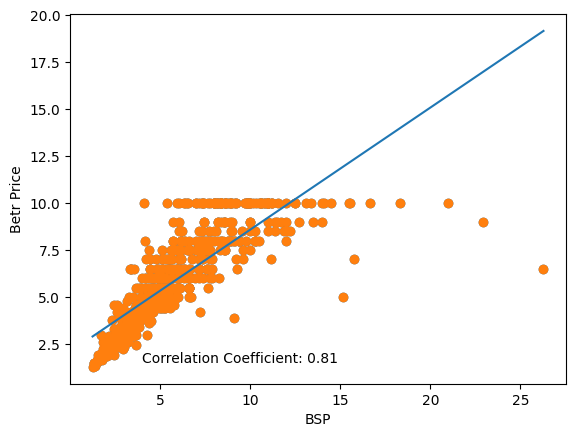

In [9]:
all_bets['betr difference'] = all_bets['BSP'] - all_bets['Price']
sum(all_bets['betr difference'])

# lets plot the correlation of the BSP with the price in the all_bets df using matplot lib:
plt.scatter(all_bets['BSP'], all_bets['Price'])
plt.scatter(all_bets['BSP'], all_bets['Price'])
plt.xlabel('BSP')
plt.ylabel('Betr Price')
plt.plot(np.unique(all_bets['BSP']), np.poly1d(np.polyfit(all_bets['BSP'], all_bets['Price'], 1))(np.unique(all_bets['BSP'])))
plt.text(4, 1.5, f'Correlation Coefficient: {round(np.corrcoef(all_bets["BSP"], all_bets["Price"])[0,1], 3)}')
print(f'On average the betr price is ${round(np.mean(all_bets["betr difference"]), 3)} off from the BSP')

#### How good would of betting with the Kelly Criterion been?

Thus far we have assumed we made \\$1 bets for every horse - but what if the bet size was a function of the implied probability we derive from the price. The below code sees how well we would of done using the kelly criterion for stake sizes assuming we initially placed \\$100 in. 

Text(0, 1200, 'initial stake: $100')

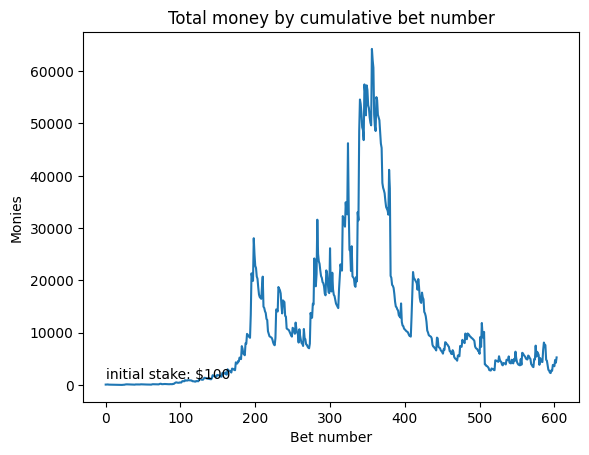

In [10]:
initial_stake = 100
bets = len(all_bets)
monies_array = [initial_stake]

def kelly_fraction(prob, prop_bet_gained):
  return ((prob) - ((1 - prob)) / prop_bet_gained) # need to check correct formula two sites differerd.

for bet in range(1,bets):
    index = bet - 1 
    prob = all_bets['implied_probability'][index]
    price = all_bets['Price'][index]
    prop_bet_gained = (price*1) /1
    kelly_frac = kelly_fraction(prob, prop_bet_gained)
    kelly = kelly_frac * monies_array[-1]

    if all_bets['WIN_LOSE'][index] == 1:
        total_purse = monies_array[-1] + (price * kelly)
        monies_array.append(total_purse)
    else:
        total_purse = monies_array[-1] - (kelly)
        monies_array.append(total_purse)

plt.plot(monies_array)
#lets add axis titles and labels:
plt.xlabel('Bet number')
plt.ylabel('Monies')
plt.title('Total money by cumulative bet number')
plt.text(0, 1200, f'initial stake: ${initial_stake}')

### *below is Ben playing around*

#### Profit from all bets- assuming BSP is long run probability. 

In [ ]:
print(f'From a total of ({len(all_bets)} bets) the overall turnover for all our bets is: {all_bets.Turnover.mean()}.')
print(f'This would equate to a profit of {round(all_bets.Turnover.mean() * 100 - 100, 3)} percent- (assuming BSP is accurate in long run)')



From a total of (337 bets) the overall turnover for all our bets is: 104.622361282017.
This would equate to a profit of 10362.236 percent- (assuming BSP is accurate in long run)


#### Profit if we had only bet when the price was better than the midpoint price:

In [11]:
print(f'From a total of ({len(midpoint_strat_profit)} bets) the overall turnover for all our bets is: {midpoint_strat_profit.Turnover.mean()}.')
print(f'This equates to a profit of {round(midpoint_strat_profit.Turnover.mean() * 100 - 100, 3)} percent.')

From a total of (310 bets) the overall turnover for all our bets is: 104.03934650702357.
This equates to a profit of 10303.935 percent.
